In [1]:
#restart the kernel if switching from inline to notebook
import matplotlib.pyplot as plt
%matplotlib notebook 
plt.style.use('seaborn-whitegrid')
import corner

import numpy as np
import numpy.linalg
import scipy.stats
from scipy.signal import argrelextrema
import pandas as pd

import emcee
import george

from subsample import subsample # daniela's code
from emcee_utils import walker_params, plot_gpfit
from plotting import plot_lightcurve, plot_folded_lightcurve, plot_mcmc_sampling_results, plot_steps

# A Motivating Example for Gaussian Processes

Lomb-Scargle periodograms have for a long time been the default go-to method for detecting periodic signals in unevenly sampled data. The problem with this approach is that not all data is sinusoidal by nature and therefore, a sine curve model is not always optimal for describing certain data. 

Getting a precise and accurate period is often necessary to reveal more information about something. In the case of asteroids, their rotational period is vital to understanding their composition and size, with intra-period variability relating to its shape. Being able to gather more information about asteroid compositions, shapes, and sizes helps us discover more about our solar system history.

With new technological advances being made in the last decade, researchers are now better computationally equipped than ever to prescribe accurate models to data. By using Gaussian Processes, we are able to fit a model to the covariance between data points, providing a much more flexible model. The use of priors allows us to also include any pre-established knowledge we have about asteroids and the typical properties they exhibit. 

In this example, we hope to show that by expanding our methods for period determination to include Gaussian Processes, we can more often arrive at the correct values.


Let's start by looking at an asteroid that already has a well determined period and lightcurve. Asteroid 221, also known as Eos, is a well-known asteroid that has had its shape, size, and period extensively documented. We have simulated lightcurve data available to us from the DAMIT database. Let's plot the full data.

Text(0,0.5,'Flux')

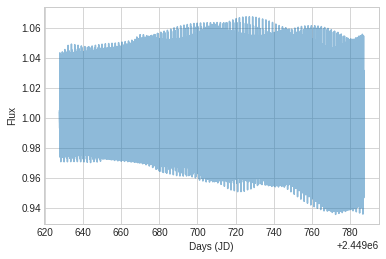

In [2]:
asteroid = '221' # there are 3 other asteroids to test if you want

true_log_p = {'3200':-1.896021, '1291':-1.45813055, 
              '221':-0.8321219, '1388':-0.69789175}
true_p = {'3200':3.603957/24, '1291':5.58410/24, 
              '221':10.443/24, '1388':11.9432/24}

# read in the data
txt = '../data/'+str(asteroid)+'_lc_49627_to_49787.txt'
data = pd.read_csv(txt, delimiter=' ', header=None, 
                   names=['time','flux'], 
                   dtype={'time':float, 'flux':float})

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(data.time, data.flux, alpha=0.5)
ax.set_xlabel("Days (JD)")
ax.set_ylabel("Flux")

This doesn't look like much of a lightcurve. Let's zoom in and look at a 1 day snapshot.

Text(0,0.5,'Flux (centered around 1)')

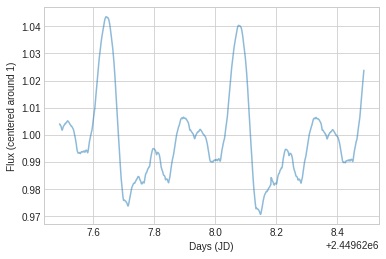

In [3]:
# you can set the delay to look at different parts of the lightcurve
days, delay = 1, 0


# convert days to points
span = 2880 * days
start_pt = 2880 * delay

time = np.array(data.time[start_pt:span+start_pt])
flux = np.array(data.flux[start_pt:span+start_pt])

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(time, flux, '-', alpha=0.5, 
        label="Original : " + str(round(true_log_p[asteroid], 5)))
ax.set_xlabel("Days (JD)")
ax.set_ylabel("Flux (centered around 1)")


Ah ha! That looks much more like a lightcurve we would expect to see from an asteroid. But this isn't what we would see if we were to actually observe it with a ground-based telescope. Let's look and see how that would look like if we observed 100 times over 5 nights.

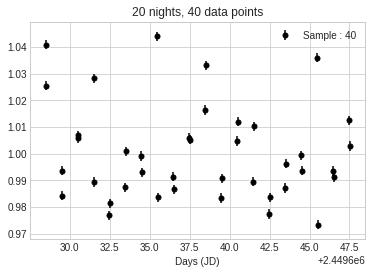

In [4]:
days, delay = 20, 1

# convert days to points
span = 2880 * days
start_pt = 2880 * delay

time = np.array(data.time[start_pt:span+start_pt])
flux = np.array(data.flux[start_pt:span+start_pt])

flux_err = np.ones_like(flux) * np.std(flux)/10.0
tsample, fsample, flux_err = subsample(time, flux, flux_err=flux_err, npoints=100, kind="ztf-lsst")

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.set_title("%i nights, %i data points"%(days, len(fsample)))
ax.set_xlabel("Days (JD)")
ax.errorbar(tsample, fsample, yerr=flux_err, fmt="o", markersize=5,
            color="black", zorder=10, 
            label="Sample : " + str(len(tsample)))
ax.legend()

In [14]:
txt = "5318.csv"
data = pd.read_csv(txt, delimiter=',')

tsample = data.mjd
fsample = data.magcorrOO
flux_err = data.sigmapsf

In [15]:
data

,Unnamed: 0,objectId,jd,fid,pid,diffmaglim,programid,candid,isdiffpos,tblid,...,exptime,obsdate,mjd,magcorrZTF,magOO,phaseangle,heliodist,geodist,velocity,magcorrOO
0,618257,ZTF18acanzmr,2.458398e+06,1,643478173315,20.7072,1,643478173315015003,t,3,...,30.0,2018-10-06T11:28:34.000,58397.477743,0.0332,18.202296,25.331173,2.285977,1.858844,0.208733,-0.369096
1,656040,ZTF18acbyomy,2.458424e+06,2,669380334015,20.4425,1,669380334015015035,t,35,...,30.0,2018-11-01T09:07:40.996,58423.379907,-0.2224,17.108835,21.461197,2.246522,1.534311,0.041417,-0.131235
2,658941,ZTF18acbzdlm,2.458424e+06,1,669411824015,20.0388,1,669411824015015017,t,17,...,30.0,2018-11-01T09:53:02.000,58423.411400,1.1469,17.629764,21.453295,2.246474,1.533948,0.040351,0.717136
3,703432,ZTF18acecblq,2.458429e+06,1,674338714015,20.7330,1,674338714015015013,t,13,...,30.0,2018-11-06T08:07:45.002,58428.338287,0.3085,17.502880,20.152149,2.238955,1.479159,0.005558,-0.094380
4,713892,ZTF18acclmmm,2.458426e+06,1,671398284015,20.5974,1,671398284015015056,t,56,...,30.0,2018-11-03T09:33:31.997,58425.397859,0.3574,17.579274,20.953106,2.243442,1.511496,0.024840,-0.021874
5,733188,ZTF18acclytu,2.458426e+06,2,671424814015,20.5414,1,671424814015015052,t,52,...,30.0,2018-11-03T10:11:43.999,58425.424387,0.3541,17.056850,20.945992,2.243401,1.511197,0.024071,0.497250
6,761853,ZTF18accufiz,2.458427e+06,1,672443654015,20.7368,1,672443654015015006,t,6,...,30.0,2018-11-04T10:38:51.999,58426.443229,1.1332,17.552317,20.676229,2.241846,1.499868,0.015642,0.780883
7,768121,ZTF18accufiz,2.458427e+06,2,672420604015,20.6931,1,672420604015015054,t,54,...,30.0,2018-11-04T10:05:40.004,58426.420174,0.1011,17.031188,20.682620,2.241882,1.500124,0.016166,0.269912
8,800860,ZTF18acemxpr,2.458430e+06,2,675403224015,20.7430,1,675403224015015034,t,34,...,30.0,2018-11-07T09:40:39.003,58429.402801,-0.5553,16.952974,19.843322,2.237331,1.467724,0.009619,-0.408274
9,804362,ZTF18acemxpr,2.458430e+06,1,675431754015,20.8236,1,675431754015015014,t,14,...,30.0,2018-11-07T10:21:44.003,58429.431331,0.4246,17.473941,19.834682,2.237288,1.467418,0.009974,0.050659


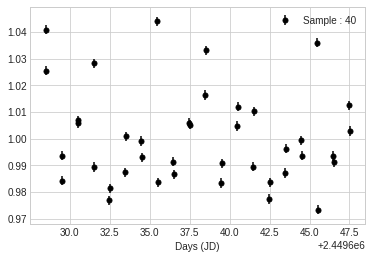

In [5]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
#ax.set_title("%i nights, %i data points"%(days, len(fsample)))
ax.set_xlabel("Days (JD)")
ax.errorbar(tsample, fsample, yerr=flux_err, fmt="o", markersize=5,
            color="black", zorder=10, 
            label="Sample : " + str(len(tsample)))
ax.legend()

In [6]:
fsample.var()


0.00031478029404972323

This is far more realistic looking and we aren't able to discern the original lightcurve. 

A quick summary of all the different data sampling we have so far. For simulated data, we have to sample it at a candence that would be similar to real observations, meaning we have 3 types of flux and time data.

1. __data.time & data.flux__ : all the time and flux data from the simulated data. This might span multiple days-months and has a data point for every 30 seconds using DAMIT generated data

2. __time & flux__ : the time and flux data for a smaller range of dates than all_time and all_flux. This is essentially the observing window in which we are working with and time is what we will be projecting our gp fits onto

3. __tsample & fsample__ : the time and flux data sampled from the time and flux data. The sampling of this is more realistic (every 10 minutes instead of every 0.5 minutes)

Let's see what a Lomb-Scargle periodogram predicts the period should be based on our data so far.

/home/christina/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


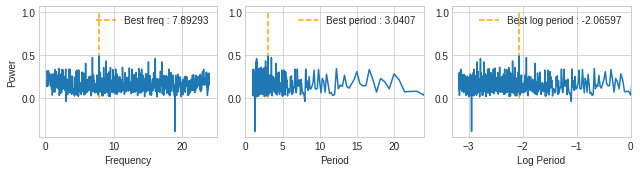

In [7]:
from lombscargle import make_lsp
from astropy.stats import LombScargle

freq, power = make_lsp(tsample, fsample, flux_err, p_max=5.0, nterms=3)

best_freq = freq[np.argmax(power)]
best_period = 1./best_freq
best_log_period = np.log(1./best_freq)

fig, (bx,cx,dx) = plt.subplots(1,3, figsize=(9,2.5))
fig.set_tight_layout('tight')

bx.plot(freq, power)
bx.set_xlabel('Frequency')
bx.set_ylabel('Power')
bx.vlines(best_freq, 0, 1, colors='orange', linestyles='--', 
          label = 'Best freq : ' + str(round(best_freq, 5)))
bx.legend()

cx.plot((1./freq)*24., power)
cx.set_xlabel('Period')
cx.vlines(best_period*24., 0, 1, colors='orange', linestyles='--', 
          label = 'Best period : ' + str(round(1./best_freq*24, 5)))
cx.set_xlim([0,24])
cx.legend()

dx.plot(np.log(1./freq), power)
dx.set_xlabel('Log Period')
dx.vlines(np.log(1./best_freq), 0, 1, colors='orange', linestyles='--', 
          label = 'Best log period : ' + str(round(np.log(1./best_freq), 5)))
dx.set_xlim([-3.3,0])
dx.legend()


Let's try and fold the lightcurve around the best guess period.

That's not a superb fit. Let's try to implement our Gaussian Processes to try and single out a better model.

We will be using the Python packages **emcee** and **george** in order to use MCMC to navigate different parameter dimensions. We will be modeling our lightcurve using the ExpSine2Kernel with the following 4 parameters.

1. Mean - where the model is centered
2. Log amplitude - the amplitude of the flux (calculated in log-space to avoid any negatives)
3. Gamma - the length scale of within-period variation
4. Log Period - the peroid (also calculated in log-space to avoid any negatives)

Because we are using MCMC, we have to set up priors to evaluate our posteroir probability. 

In [59]:
def prior(params):

    """
    Calculated the log of the prior values, given parameter values.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    param[0] : float
        mean (between 0 and 2)

    param[1] : float
        log amplitude (between -10 and 10)

    param[2] : float
        gamma (log gamma between 0.1 and 40)

    param[3] : float
        log period (period between 1h and 24hrs)

    Returns
    -------
    sum_log_prior : int
        sum of all log priors (-inf if a parameter is out of range)

    """

    p_mean = scipy.stats.norm(1, 0.5).logpdf(params[0])
    #p_log_amp = scipy.stats.uniform(-10,30).logpdf(params[1])
    p_log_amp = scipy.stats.norm(np.log(0.15), np.log(2)).logpdf(params[1])
    p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[2]))
    ###print this line to get the prob value: p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[2]))
    p_period = scipy.stats.uniform(np.log(1./24.), -np.log(1./24.)).logpdf((params[3]))

    sum_log_prior =  p_mean + p_log_amp + p_log_gamma + p_period

    if np.isnan(sum_log_prior) == True:
        return -np.inf

    return sum_log_prior

def logl(params, gp, tsample, fsample, flux_err):
    # compute lnlikelihood based on given parameters
    gp.set_parameter_vector(params)

    try:
        gp.compute(tsample, flux_err)
        lnlike = gp.lnlikelihood(fsample)
    except np.linalg.LinAlgError:
        lnlike = -1e25
    return lnlike

def post_lnlikelihood(params, gp, tsample, fsample, flux_err):

    """
    Calculates the posterior likelihood from the log prior and
    log likelihood.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    Returns
    -------
    ln_likelihood : float
        The posterior, unless the posterior is infinite, in which case,
        -1e25 will be returned instead.

    """

    # calculate the log_prior
    log_prior = prior(params)

    # return -inf if parameters are outside the priors
    if np.isneginf(log_prior) == True:
        return -np.inf

    try:
        lnlike = logl(params, gp, tsample, fsample, flux_err)
        ln_likelihood = lnlike+log_prior

    except np.linalg.linalg.LinAlgError:
        ln_likelihood = -1e25

    return ln_likelihood if np.isfinite(ln_likelihood) else -1e25

In [60]:
x = np.linspace(-5,100, 10000)

In [17]:
r = scipy.stats.norm(np.log(0.1), np.log(5)).logpdf(np.log(x))

/home/christina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


/home/christina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
/home/christina/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/home/christina/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/home/christina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


Text(0.5,1,'Variance : 0.00031478029404972323')

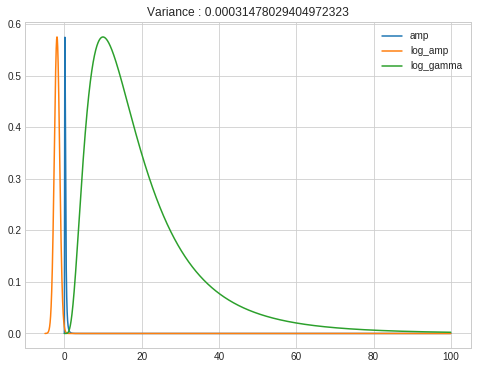

In [50]:
amp = scipy.stats.norm(np.log(0.15), np.log(2)).logpdf(np.log(x))
log_amp = scipy.stats.norm(np.log(0.15), np.log(2)).logpdf((x))

p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(x))
#hc = scipy.stats.halfcauchy(np.log(0), np.log(2)).logpdf(np.log(x))
#h_norm = scipy.stats.halfnorm(np.log(0.15), np.log(2)).logpdf(np.log(x))

var = fsample.var()
fig, ax = plt.subplots(1, 1, figsize= (8,6))
#ax.plot(x,np.exp(hc), label = 'half-cauchy')
ax.plot(x,np.exp(amp), label = "amp")
ax.plot(x,np.exp(log_amp), label = "log_amp")
ax.plot(x, np.exp(p_log_gamma), label="log_gamma")
#ax.plot(x,np.exp(h_norm), label = "half_normal")
ax.legend()
ax.set_title("Variance : " + str(var))

In [ ]:
var = fsample.var()
fig, ax = plt.subplots(1, 1, figsize= (8,6))
ax.plot(x,np.exp(hc), label = 'half-cauchy')
ax.plot(x,np.exp(norm), label = "normal")
ax.plot(x,np.exp(h_norm), label = "half_normal")
ax.legend()
ax.set_title("Variance : " + str(var))
ax.set_xlim([0,var*2])

ax.set_ylim([0,0.000001])
#ax.set_yscale('log')

In [ ]:
def sqr_exp (x1, x2):
    return np.exp(-(x1**2-x2**2 - 2*np.dot(x1,x2))**2)

In [ ]:
x = np.linspace(-5,5, 1000)
y = scipy.stats.norm(0,1).pdf(x)
#y = sqr_exp(2, x)

fig, ax = plt.subplots(1, 1)
ax.plot(x,y)

How many walkers do we want? Let's start with 100 for a good measure.

In [52]:
ndim, nwalkers = 4, 100

Now we need to set up our starting parameter values. We can make an educated guess using the Lomb-Scargle period and other averages, and then spread out those guesses using a covariance matrix. If you want to spread the guesses more out or bring them closer together, you can adjust the **cov_scale**.

In [53]:
# initialize walker parameters
gp_mean = np.mean(fsample)
log_amp = np.log(fsample.max()-fsample.min())
gamma = 1
log_period = best_log_period

params = [np.mean(fsample), log_amp, gamma, log_period]

# set up gp kernel
kernel = np.exp(log_amp) * george.kernels.ExpSine2Kernel(gamma = gamma, log_period = log_period)
gp = george.GP(kernel, fit_mean=True, mean=gp_mean)
gp.compute(tsample, flux_err)

# equally distributed starting period values
p_start = np.array(params)/100.
cov_matrix = np.sqrt(np.diag(p_start)**2)
p0 = np.random.multivariate_normal(mean=params, cov=cov_matrix, size=(nwalkers))
x = np.log(np.linspace(2,12,nwalkers)/24.)
p0[:,3] = x


Now we have to set up our sampler for the MCMC walkers and detail how it should be calculating the log likelihood.

In [65]:
threads=1
sampler = emcee.EnsembleSampler(nwalkers, ndim, post_lnlikelihood, args=[gp, tsample, fsample, flux_err], threads=threads)

And now let's run the sampler! You can specify how many steps you want the walkers to take. A minimum of 500 is highly recommended. And remember, depending on what sort of machine you're running this on, this might take some time.

In [66]:
%%time
mcmc_sampling = sampler.run_mcmc(p0, 2000)

/home/christina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log


CPU times: user 9min 4s, sys: 815 ms, total: 9min 5s
Wall time: 9min 4s


Let's plot the path of the walkers to get a better picture of what happened.

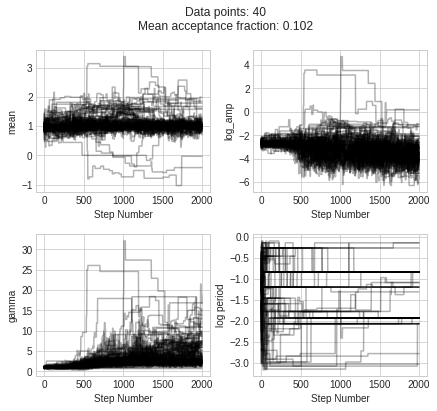

In [67]:
plot_steps(sampler, dims = ['mean', 'log_amp', 'gamma', 'log period'], p0=[params], data_pts=len(fsample))

The distribution of periods ended up looking like this.

Text(0.5,0,'Period (hours)')

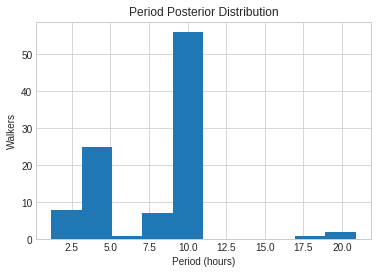

In [68]:
# sampler.chain[chain, step, dimension]
end_period = sampler.chain[:,-1,-1]
end_period.sort()

fig, fx = plt.subplots(1,1)
fx.hist(np.exp(end_period)*24.)
fx.set_title('Period Posterior Distribution')
fx.set_ylabel('Walkers')
fx.set_xlabel('Period (hours)')

We can now see how the different posterior distributions model the original sampled data. Feel free to give the file names **namestr** an appropriate title.

[ 1.03880538 -3.37086576  2.57013571 -0.83281583]
[ 0.96266626 -2.75796608  0.94455866 -1.93141498]
[ 1.01238982 -2.61485794  1.1247507  -0.83319068]
[ 0.89132711 -2.54250566  0.85386295 -2.0669806 ]
[ 1.08518512 -2.82622273  1.10224252 -1.19378211]
[ 0.96349914 -2.59001584  1.58732465 -0.83276204]
[ 0.99880932 -2.64514478  0.94470328 -3.07721388]
[ 0.98678281 -2.76444808  1.98964967 -0.83287199]
[ 1.08978453 -4.40899355  3.90206919 -2.06687169]
[ 1.06025251 -2.79801401  5.50685887 -1.93154865]


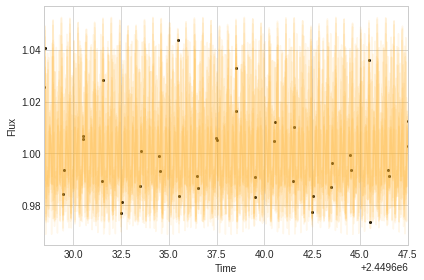

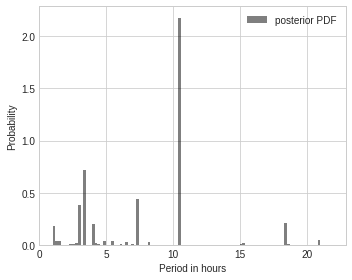

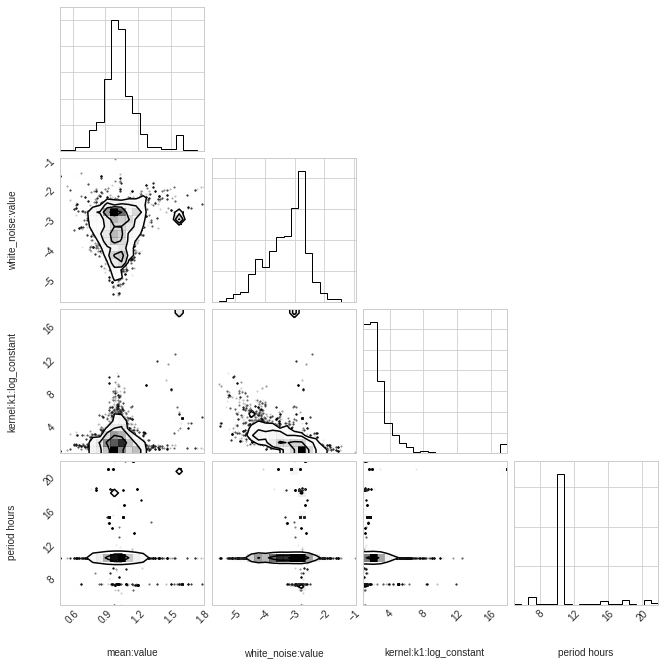

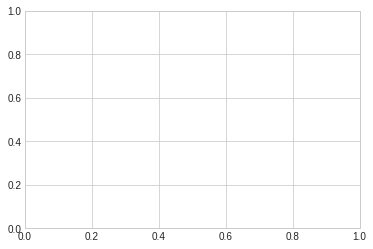

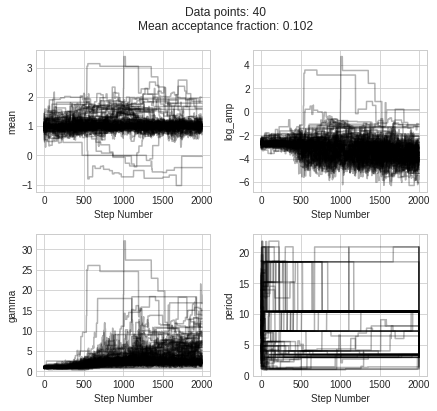

In [69]:
def save_chain(file_name, sampler):
        header = str(sampler.chain.shape)
        np.savetxt(file_name, sampler.flatchain, header=header)
        return

filename = "test"

save_chain(filename + "_results.txt", sampler)

plot_mcmc_sampling_results(np.array(tsample), fsample, flux_err, gp, sampler, namestr=filename + "_plots")

Hopefully, most of the walkers will have converged onto the correct period. Typically, the longer you run it, the more likely all the walkers will settle onto the correct value. 

In [71]:
np.exp(-5)

0.006737946999085467

In [ ]:
# resample from weights
new_samples = sampler.flatchain
print(new_samples)

In [ ]:
labels = list(gp.parameter_names)
print(labels)
type(labels)
#labels
labels[3] = 'period hours'
print(labels[3])
corner.corner(new_samples[int(-len(new_samples)*0.1):], labels=labels)

## Presentation Graphs : AAS 233 and DPS 50

In [ ]:
# you can set the delay to look at different parts of the lightcurve
days, delay = 1, 0


# convert days to points
span = 2880 * days
start_pt = 2880 * delay

time = np.array(data.time[start_pt:span+start_pt])
flux = np.array(data.flux[start_pt:span+start_pt])

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(time, flux, '-', alpha=1, 
        label="Original : " + str(round(true_log_p[asteroid], 5)))
ax.set_xlabel("Time", fontsize=25)
ax.set_ylabel("Brightness", fontsize=25)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlim([time[0], time[-1]])

In [ ]:
days, delay = 5, 0

# convert days to points
span = 2880 * days
start_pt = 2880 * delay

time = np.array(data.time[start_pt:span+start_pt])
flux = np.array(data.flux[start_pt:span+start_pt])

flux_err = np.ones_like(flux) * np.std(flux)/10.0
tsample, fsample, flux_err = subsample(time, flux, flux_err=flux_err, npoints=20, kind="telescope")

fig, ax = plt.subplots(1,1, figsize=(9,6))
#ax.set_title("%i nights, %i data points"%(days, len(fsample)))
ax.set_xlabel("Days (JD)")
ax.errorbar(tsample, fsample, yerr=flux_err, fmt="o", markersize=5,
            color="black", zorder=10)#, 
            #label="Sample : " + str(len(tsample)))

ax.plot(time, flux, '-', alpha=0.3)#, 
        #label="Original : " + str(round(true_log_p[asteroid], 5)))
ax.set_xlabel("Time", fontsize=25)
ax.set_ylabel("Brightness", fontsize=25)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlim([time[0], time[-1]])
#ax.legend()

In [ ]:
fig, cx = plt.subplots(1,1, figsize=(9,6))
cx.plot((1./freq)*24.,power)
cx.set_xlabel('Period', fontsize=25)
cx.vlines(best_period*24., 0, 1, colors='orange', linestyles='--', 
          label = 'Best period : ' + str(round(1./best_freq*24., 5)))
cx.set_xlim([0,24])
cx.set_ylim([0,1])
cx.legend()

In [ ]:
# resample from weights
new_samples = sampler.flatchain

# plot some light curves with example models

# first, get the total number of available samples
nsamples = new_samples.shape[0]

# plot histogram of periods
fig, ax = plt.subplots(1, 1, figsize=(9,6))
ax.hist((sampler.chain[:,-1,-1]), bins=100, density=True,
            label="posterior PDF", color="black", alpha=0.5)

#if true_period is not None:


ax.set_xlabel("Period in hours", fontsize=25)
ax.set_ylabel("Probability", fontsize=25)


ylim = ax.get_ylim()
print(true_p[asteroid])
ax.vlines(true_p[asteroid]*24, 0, ylim[1], lw=1, color="blue", 
          linestyle="dashed", label="true period : " + str(true_p[asteroid]*24))

ax.vlines(best_period*24., 0, ylim[1], lw=1, color="red", 
          linestyle="dashed", label="l-s period : " + str(round(best_period*24.,5)))
ax.set_xlim([0,24])
ax.set_yticklabels([])

plt.tight_layout()

ax.legend()
#plt.savefig(namestr + "_period_pdf.pdf", format="pdf")